In [12]:
from dotenv import load_dotenv
load_dotenv()

True

In [13]:
from langchain_community.document_loaders import PyPDFLoader

pdf_loader = PyPDFLoader('./data/proposal.pdf') #  data 폴더 안에 들어있습니다.
pdf_docs = pdf_loader.load()


In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200, # 문맥을 살리기 위해서 겹치는 부분 크기
    length_function = len, # 글자 수를 기준 -> 이걸 왜씀? 청크 사이즈 1000이 글자수 1000이 되도록 한다.
    separators = ["\n\n", "\n", " ", ""], # 여러 기준으로 청크 나누기가 가능, 앞에 나오는 것 우선 -> 이게 RecursiveCharacterTextSplitter의 핵심 기능
)
texts = text_splitter.split_documents(pdf_docs)

In [15]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model = "text-embedding-3-large")

embeddings_model

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x0000023457CA1850>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x000002345C194250>, model='text-embedding-3-large', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [16]:
from langchain_chroma import Chroma

# req_store = Chroma.from_documents(
#     documents=texts,
#     embedding=embeddings_model,
#     collection_name='chroma-req',
#     persist_directory='../chroma-req'
# )

# 데이터 로딩
vector_store = Chroma(
    collection_name='chroma-req',
    embedding_function=embeddings_model,
    persist_directory='./chroma-req'
)

retriever = vector_store.as_retriever(search_kwargs={'k':3})

In [17]:
from typing import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class ReqState(TypedDict):
    req_actor: List[str]
    req_names: List[str]
    req_purpose: List[str]
    req_importance: List[str]
    req_level: List[str]
    req_function: List[str]
    req_process: List[str]
    req_screen: List[str]
    req_security: List[str]
    req_perform: List[str]
    req_data: List[str]

    context : List[Document]

In [18]:
import pandas as pd 
def generate_df(state:ReqState) -> ReqState:
    df = pd.DataFrame({
        "시스템": state["req_actor"],
        "요구사항 ID": [f"REQ-{str(i).zfill(3)}" for i in range(1, len(state["req_names"]) + 1)],
        "요구사항명": state["req_names"],
        "중요도": state["req_importance"],
        "난이도": state["req_level"],
        "요청목적": state["req_purpose"],
        "기능 요구사항": state["req_function"],
        "프로세스 요구사항": state["req_process"],
        "화면 요구사항": state["req_screen"],
        "보안 요구사항": state["req_security"],
        "성능 및 용량 요구사항": state["req_perform"],
        "데이터 요구사항": state["req_data"],
    })
    
    df.to_csv("requirements.csv", index=False, encoding="utf-8-sig")

    return state 
    


In [19]:
from sj import graph_sj as sj_subgraph
from jy import graph_jy as jy_subgraph
from mj import graph_mj as mj_subgraph


graph_builder = StateGraph(ReqState)

graph_builder.add_node("jy_agent", jy_subgraph)
graph_builder.add_node("mj_agent", mj_subgraph)
graph_builder.add_node('sj_agent', sj_subgraph)
graph_builder.add_node('generate_df', generate_df)

In [20]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'mj_agent')
graph_builder.add_edge('mj_agent', 'jy_agent')
graph_builder.add_edge('jy_agent', 'sj_agent')
graph_builder.add_edge('sj_agent', 'generate_df')
graph_builder.add_edge('generate_df', END)

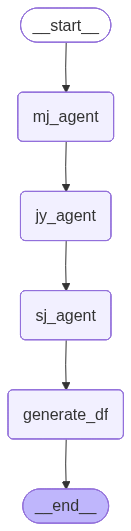

In [21]:
graph = graph_builder.compile()
graph

In [ ]:
response = graph.invoke({"context" : texts})

['팬 창작자', '일반 팬', '아티스트/소속사', '플랫폼 관리자', '외부 기업/커뮤니티', '저작권자']
['팬 창작자', '팬 창작자', '팬 창작자', '팬 창작자', '일반 팬', '일반 팬', '일반 팬', '일반 팬', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '아티스트/소속사', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '플랫폼 관리자', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '외부 기업/커뮤니티', '저작권자', '저작권자', '저작권자', '저작권자']
['팬 콘텐츠 등록 및 관리', '활동 증명 뱃지 획득', '보상 풀 분배 참여', '응원 시스템 참여', '콘텐츠 응원 및 랭킹 참여', '활동 증명 뱃지 확인', '보상 내역 확인', '팬 창작자와의 소통', '신곡 홍보 및 이벤트 관리', '팬 창작자 보상 관리', '저작권 관리 및 수익 분배', '팬덤 활성화 전략 수립', '플랫폼 기능 모니터링 및 유지보수', '보상 풀 관리 및 투명성 확보', '사용자 데이터 관리', '시스템 보안 및 안정성 관리', '스폰서십 및 후원금 관리', '팬덤 활성화 프로그램 참여', '브랜드 홍보 및 마케팅', '커뮤니티와의 협력 및 소통', '저작권 수익 분배 관리', '저작권 침해 모니터링', '저작권 관련 법적 지원', '창작자와의 협력 및 소통']
